In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import sys


import sklearn.metrics as metrics

import shap

import argparse


import dataframe_image as dfi
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import sklearn
from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from sklearn import tree
from sklearn.inspection import permutation_importance

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import warnings
from sklearn.inspection import permutation_importance

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.linear_model import Perceptron
import openpyxl

from sklearn import svm
from sklearn.metrics import matthews_corrcoef
warnings.filterwarnings(action='ignore')

In [ ]:

# Parameters to set before experiments

level = "species"

cv_num=5
display_num = 10

In [12]:
data_name = 'raw'
training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,0))

feature_index_list = np.arange(1,training_features.shape[1]+1)
feature_name = np.arange(1,training_features.shape[1]+1)

In [13]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Standard from raw model

In [14]:
data_name = 'raw'
training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,0))

feature_index_list = np.arange(1,training_features.shape[1]+1)
feature_name = np.arange(1,training_features.shape[1]+1)

In [15]:
for fold_num in range(cv_num):

    new = np.load("../classification/%s/%s/standard/%s_standard_score_training.npy"%(level,data_name,fold_num))
    before = np.load("../classification/%s/%s/standard_before/%s_standard_score_training.npy"%(level,data_name,fold_num))
    print(np.sum(new-before))
    print(np.sum(np.abs(new-before)))

0.011155378486056078
0.011155378486056078
0.00717131474103605
0.00717131474103605
0.011155378486056078
0.011155378486056078
0.010358565737052072
0.010358565737052072
0.006369426751592577
0.006369426751592577


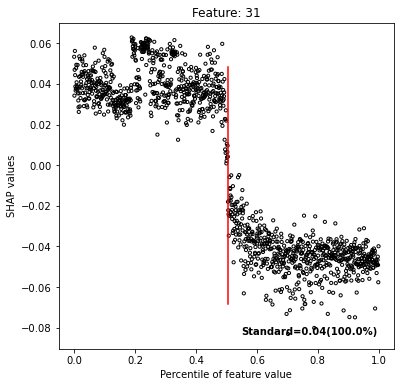

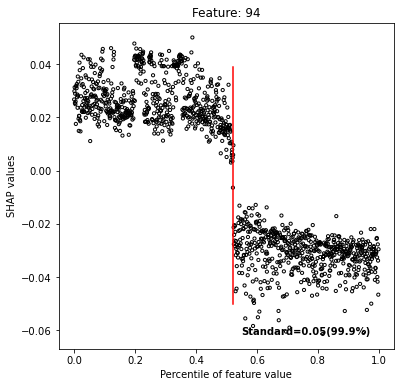

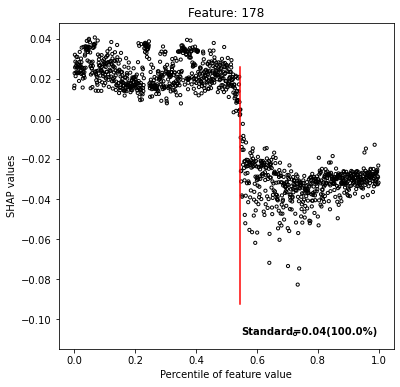

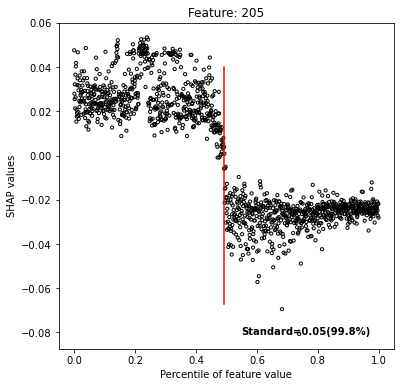

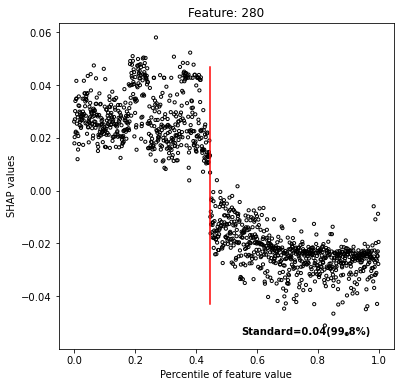

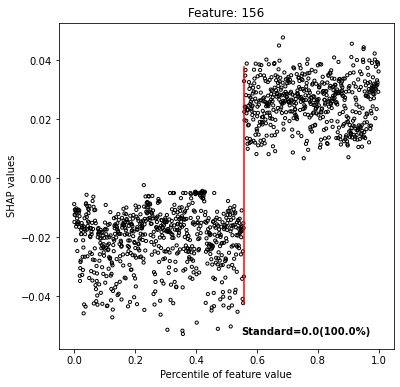

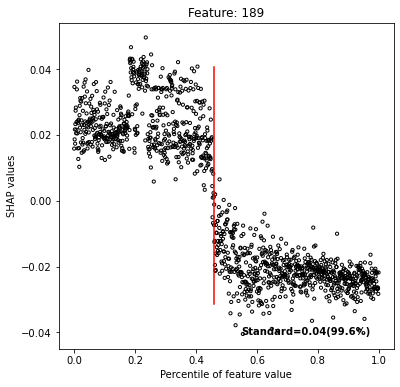

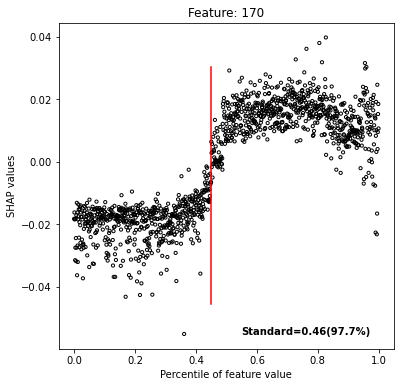

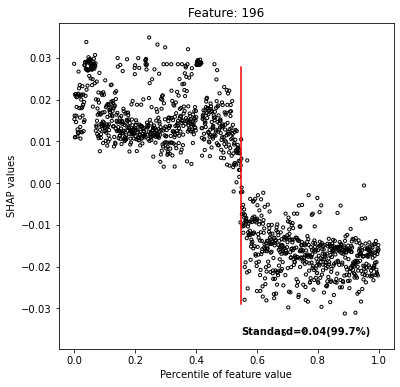

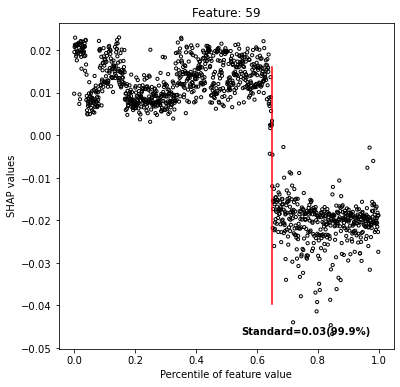

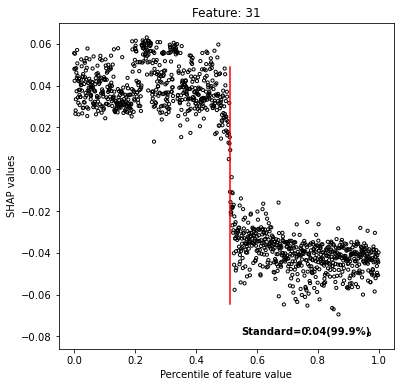

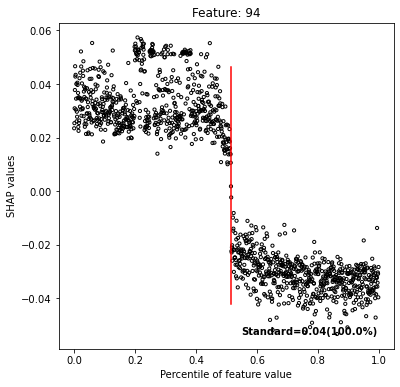

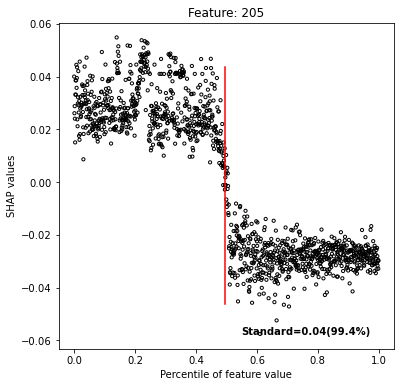

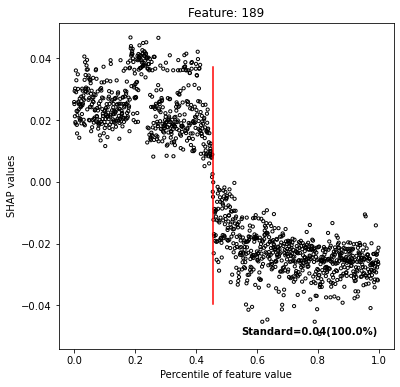

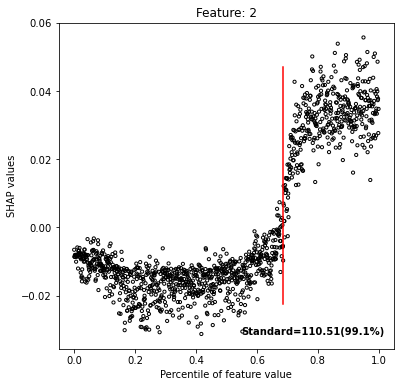

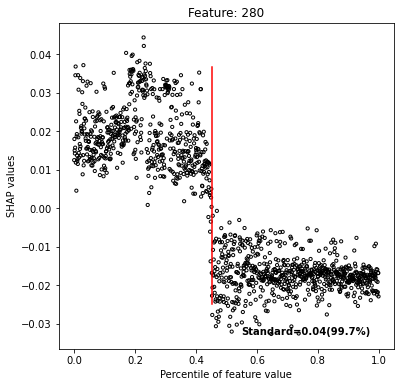

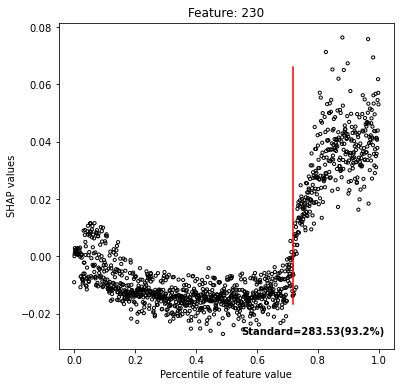

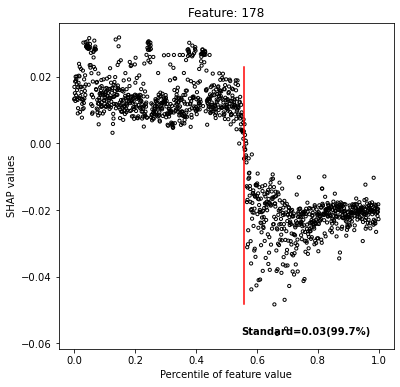

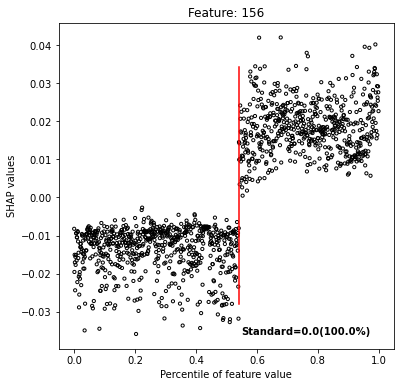

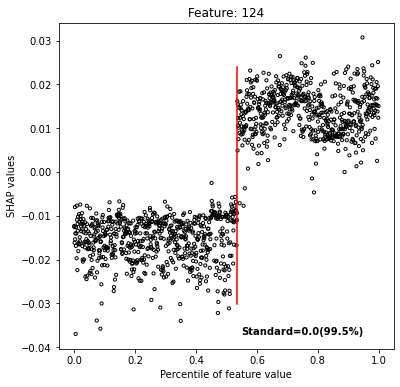

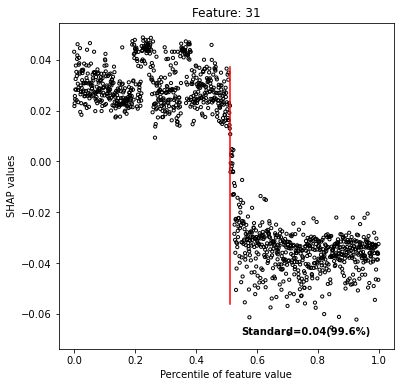

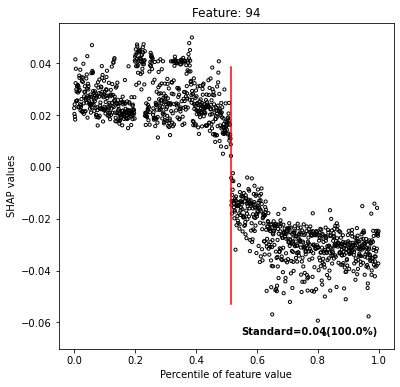

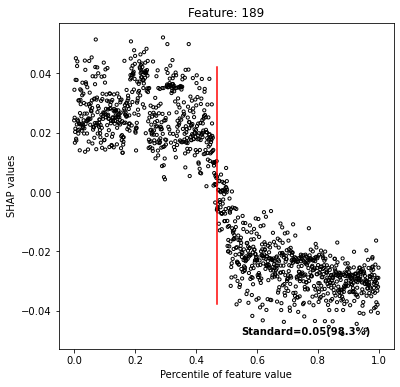

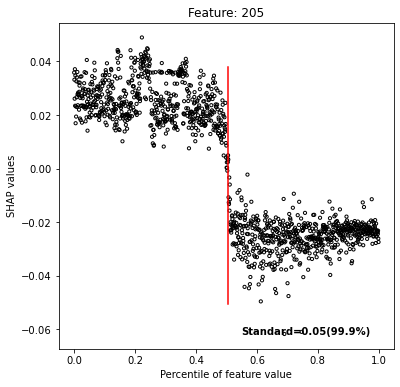

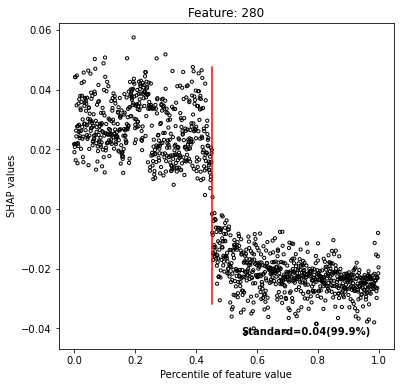

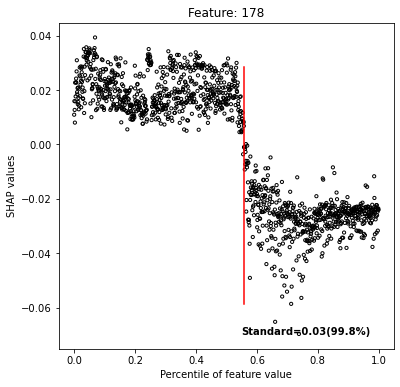

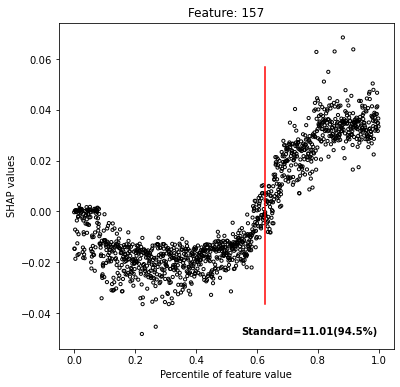

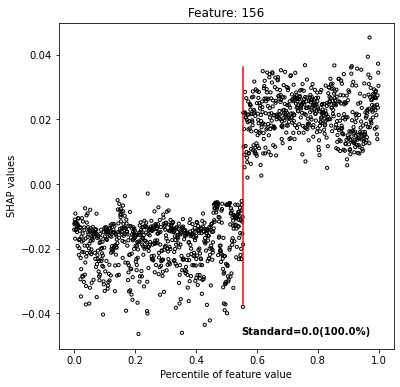

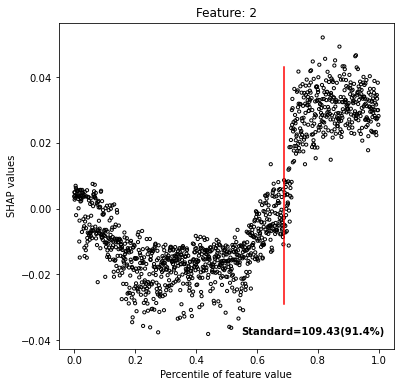

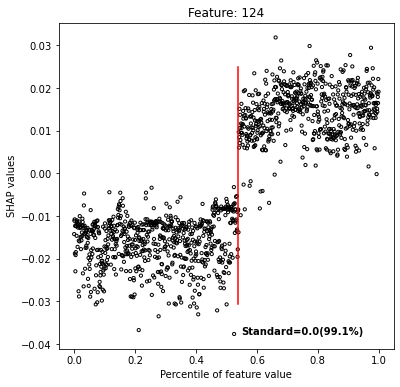

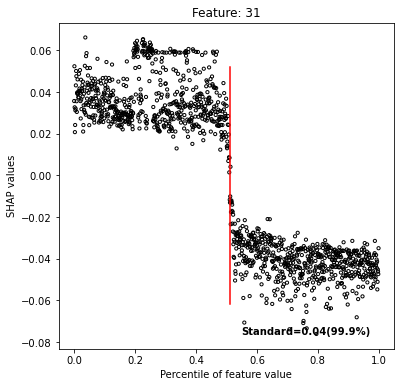

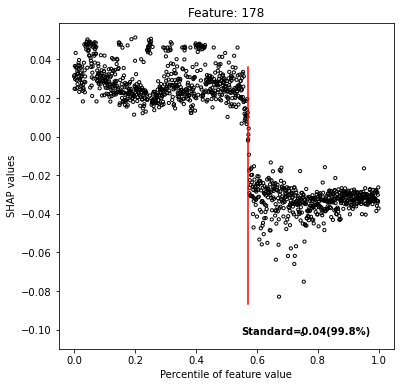

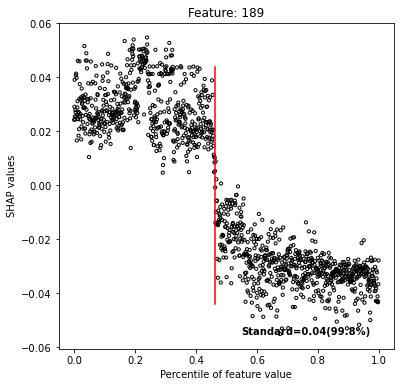

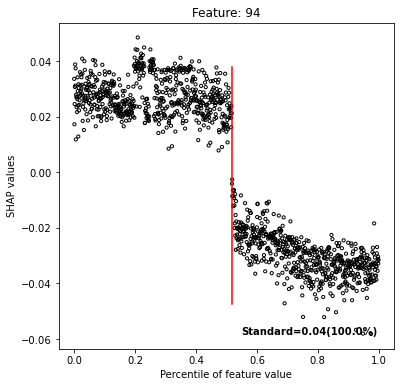

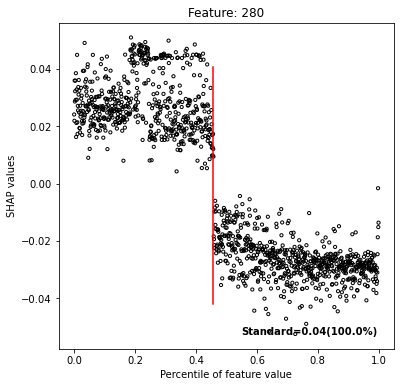

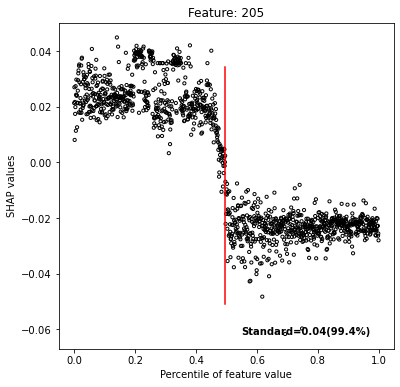

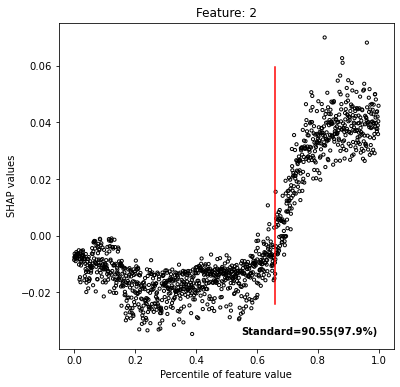

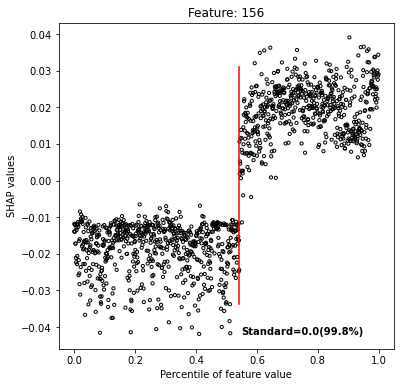

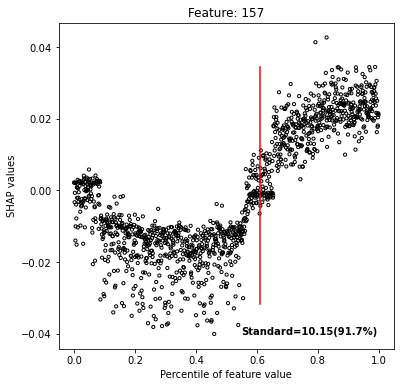

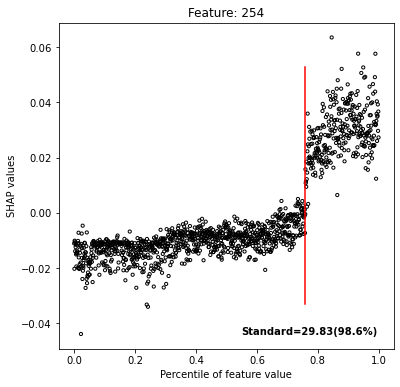

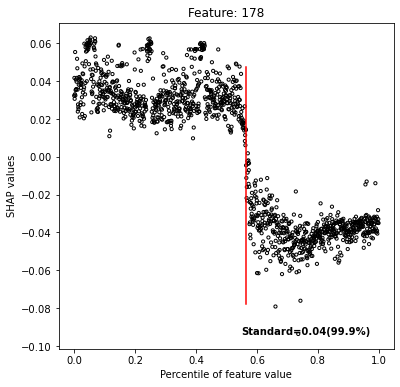

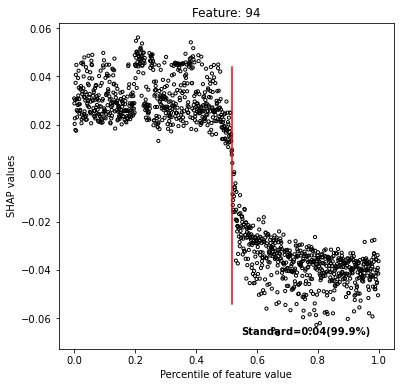

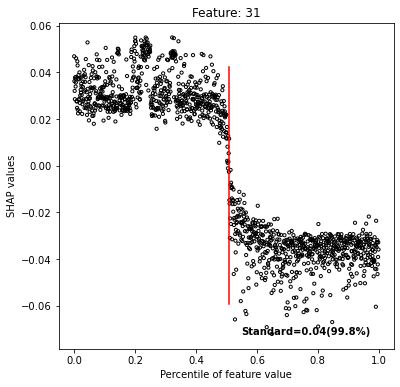

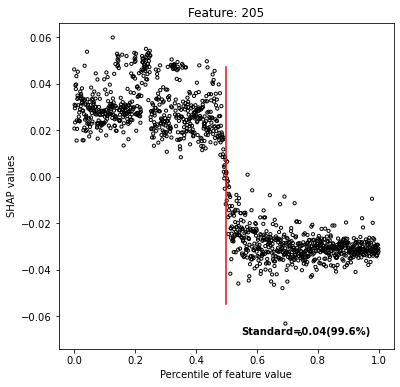

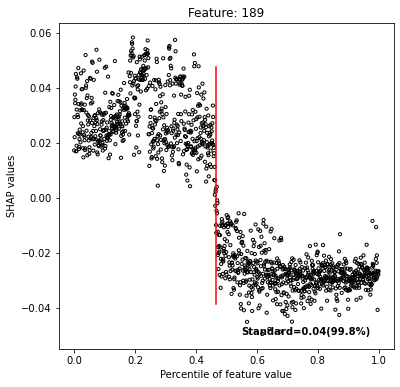

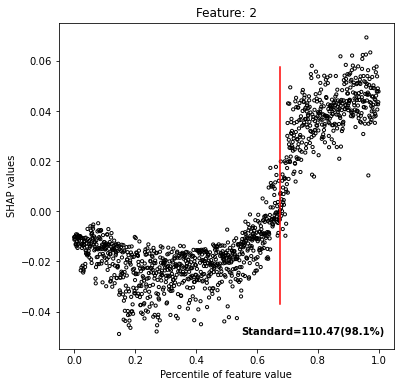

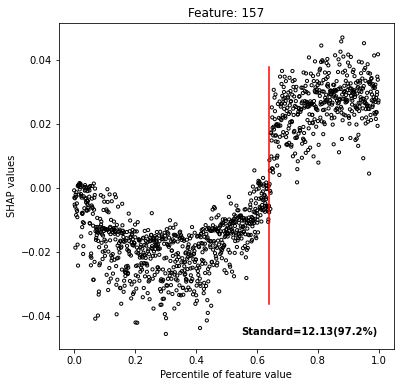

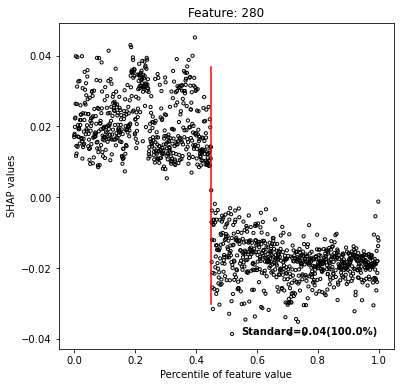

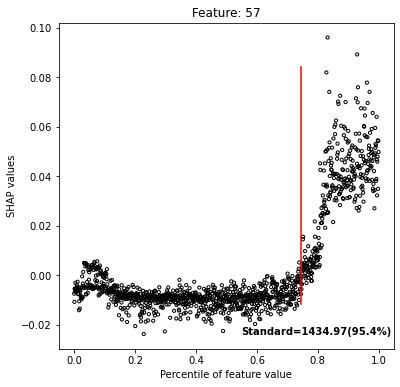

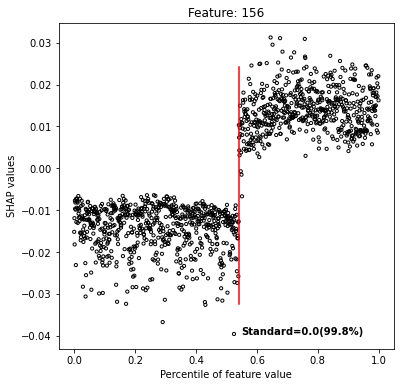

In [16]:
for fold_num in range(cv_num):
    
    
    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))
    test_diff_features =  np.load('../../Dataset/raw/%s/external_features.npy'%(level))



    
    temp_randomforest_shap_values = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values.npy"%(level,data_name,fold_num)).copy()
    temp_randomforest_shap_values_test = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test.npy"%(level,data_name,fold_num)).copy()
    temp_randomforest_shap_values_test_diff = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test_diff.npy"%(level,data_name,fold_num)).copy()

    
    feature_name_array = np.array(feature_name)

    randomforest_shap = np.average(np.abs(temp_randomforest_shap_values.copy()),axis=0)
    randomforest_shap = randomforest_shap.reshape(len(feature_name),)
    rank = randomforest_shap.argsort()[::-1]

    
    
    
    ################################################################################################################
    # standard calculation, score evaluation
    ################################################################################################################
    
    standard_vector = np.zeros(training_features.shape[1])
    score_standard_vector  = np.zeros(training_features.shape[1])

    for feature_index in range(training_features.shape[1]):
        org_vector = training_features[:,feature_index].copy()
        grid_vector = np.unique(org_vector[org_vector.argsort()]).copy()
        score_vector = np.zeros((grid_vector.shape))
        for comp_index in range(grid_vector.shape[0]-1):
            under_values = temp_randomforest_shap_values[org_vector<=grid_vector[comp_index],feature_index]
            over_values = temp_randomforest_shap_values[org_vector>grid_vector[comp_index],feature_index]

            if not (under_values.shape[0]+over_values.shape[0]) == training_features.shape[0]:
                print("error")

            pos = (np.sum(under_values<=0)+np.sum(over_values>=0))/training_features.shape[0]
            neg = (np.sum(under_values>=0)+np.sum(over_values<=0))/training_features.shape[0]

            score_vector[comp_index] = np.max([pos,neg])
        standard_vector[feature_index] = grid_vector[np.argmax(score_vector)]
        score_standard_vector[feature_index] = np.max(score_vector)
        
    np.save("../classification/%s/%s/standard/%s_SHAP_standard.npy"%(level,data_name,fold_num),standard_vector)
    np.save("../classification/%s/%s/standard/%s_standard_score_training.npy"%(level,data_name,fold_num),score_standard_vector)
    
    
    
    
    score_vector_test  = np.zeros(test_features.shape[1])

    for feature_index in range(training_features.shape[1]):
        org_vector = test_features[:,feature_index].copy()

        under_values = temp_randomforest_shap_values_test[org_vector<=standard_vector[feature_index],feature_index]
        over_values = temp_randomforest_shap_values_test[org_vector>standard_vector[feature_index],feature_index]

        if not (under_values.shape[0]+over_values.shape[0]) == test_features.shape[0]:
            print("error")

        pos = (np.sum(under_values<=0)+np.sum(over_values>=0))/test_features.shape[0]
        neg = (np.sum(under_values>=0)+np.sum(over_values<=0))/test_features.shape[0]

        score_vector_test[feature_index] = np.max([pos,neg])
    
    np.save("../classification/%s/%s/standard/%s_standard_score_test.npy"%(level,data_name,fold_num),score_vector_test)

    
    
    
    
        
    score_vector_test_zero_thres  = np.zeros(test_features.shape[1])

    for feature_index in range(training_features.shape[1]):
        org_vector = test_features[:,feature_index].copy()

        under_values = temp_randomforest_shap_values_test[org_vector<=0,feature_index]
        over_values = temp_randomforest_shap_values_test[org_vector>0,feature_index]

        if not (under_values.shape[0]+over_values.shape[0]) == test_features.shape[0]:
            print("error")

        pos = (np.sum(under_values<=0)+np.sum(over_values>=0))/test_features.shape[0]
        neg = (np.sum(under_values>=0)+np.sum(over_values<=0))/test_features.shape[0]

        score_vector_test_zero_thres[feature_index] = np.max([pos,neg])
    
    np.save("../classification/%s/%s/standard/%s_standard_score_test_zero_thres.npy"%(level,data_name,fold_num),score_vector_test_zero_thres)

    
    
    
    
    
    
    score_vector_test_diff  = np.zeros(test_diff_features.shape[1])

    for feature_index in range(training_features.shape[1]):
        org_vector = test_diff_features[:,feature_index].copy()

        under_values = temp_randomforest_shap_values_test_diff[org_vector<=standard_vector[feature_index],feature_index]
        over_values = temp_randomforest_shap_values_test_diff[org_vector>standard_vector[feature_index],feature_index]

        if not (under_values.shape[0]+over_values.shape[0]) == test_diff_features.shape[0]:
            print("error")

        pos = (np.sum(under_values<=0)+np.sum(over_values>=0))/test_diff_features.shape[0]
        neg = (np.sum(under_values>=0)+np.sum(over_values<=0))/test_diff_features.shape[0]

        score_vector_test_diff[feature_index] = np.max([pos,neg])
    
    np.save("../classification/%s/%s/standard/%s_standard_score_test_diff.npy"%(level,data_name,fold_num),score_vector_test_diff)

    
    
    
    
    
    ################################################################################################################
    # SHAP importance regarding the relative size
    ################################################################################################################
    
    for i in rank[0:display_num]:
        plt.figure(figsize=(6, 6))
        org_vector = training_features[:,i].copy()
        rank_each = org_vector.argsort()
        rel_vector = np.zeros(org_vector.shape[0])
        temp = 0 
        for data_index in range(org_vector.shape[0]):
            rel_vector[rank_each[data_index]] = temp/org_vector.shape[0]
            temp+=1
        plt.scatter(rel_vector,temp_randomforest_shap_values[:,i],s=10, facecolors='none', edgecolors='black')


        standard = np.max(np.where(org_vector[org_vector.argsort()]==standard_vector[i]))/org_vector.shape[0]

        shap_length = np.max(temp_randomforest_shap_values[:,i])-np.min(temp_randomforest_shap_values[:,i])
        plt.plot([standard,standard],[np.min(temp_randomforest_shap_values[:,i])+shap_length*0.1,np.max(temp_randomforest_shap_values[:,i])-shap_length*0.1],color="red")
        plt.xlabel("Percentile of feature value")
        plt.ylabel("SHAP values")
        plt.title("Feature: %s"%(feature_name[i]))
        text = "Standard=%s(%s%s)"%(np.round(standard_vector[i],2),np.round(100*score_standard_vector[i],1),"%")
        plt.text(0.55, np.min(temp_randomforest_shap_values[:,i]),text, weight='bold')

    #     plt.savefig('../result_with_selected_features/%s/#%s/shap_percentile/%s.jpg'%(level,data_num,feature_name[i]), dpi=500, bbox_inches='tight')
        plt.savefig('../classification/%s/%s/shap_percentile/%s_%s.jpg'%(level,data_name,feature_name[i],fold_num), dpi=500, bbox_inches='tight')


        
        

    ################################################################################################################
    # Binarization by zero
    ################################################################################################################


    binary_training_features = training_features.copy()
    for i in range(binary_training_features.shape[0]):
        for j in range(binary_training_features.shape[1]):
            binary_training_features[i][j] = 0 if binary_training_features[i][j]==0 else 1 

    binary_test_features = test_features.copy()
    for i in range(binary_test_features.shape[0]):
        for j in range(binary_test_features.shape[1]):
            binary_test_features[i][j] = 0 if binary_test_features[i][j]==0 else 1 



    binary_test_diff_features = test_diff_features.copy()
    for i in range(binary_test_diff_features.shape[0]):
        for j in range(binary_test_diff_features.shape[1]):
            binary_test_diff_features[i][j] = 0 if binary_test_diff_features[i][j]==0 else 1 
    np.save('../../Dataset/%s/%s/%s_training_features.npy'%("binarized_zero",level,fold_num),binary_training_features)
    np.save('../../Dataset/%s/%s/%s_test_features.npy'%("binarized_zero",level,fold_num),binary_test_features)
    np.save('../../Dataset/%s/%s/%s_test_diff_features.npy'%("binarized_zero",level,fold_num),binary_test_diff_features)






    ################################################################################################################
    # Binarization by standard
    ################################################################################################################

    binary_training_features = training_features.copy()
    for i in range(binary_training_features.shape[0]):
        for j in range(binary_training_features.shape[1]):
            binary_training_features[i][j] = 0 if binary_training_features[i][j]<= standard_vector[j] else 1 




    binary_test_features = test_features.copy()
    for i in range(binary_test_features.shape[0]):
        for j in range(binary_test_features.shape[1]):
            binary_test_features[i][j] = 0 if binary_test_features[i][j]<= standard_vector[j] else 1 


    binary_test_diff_features = test_diff_features.copy()
    for i in range(binary_test_diff_features.shape[0]):
        for j in range(binary_test_diff_features.shape[1]):
            binary_test_diff_features[i][j] = 0 if binary_test_diff_features[i][j]<= standard_vector[j] else 1 



    np.save('../../Dataset/%s/%s/%s_training_features.npy'%("binarized_standard",level,fold_num),binary_training_features)
    np.save('../../Dataset/%s/%s/%s_test_features.npy'%("binarized_standard",level,fold_num),binary_test_features)
    np.save('../../Dataset/%s/%s/%s_test_diff_features.npy'%("binarized_standard",level,fold_num),binary_test_diff_features)



        

# SHAP summary plot from raw model with binarized dataset

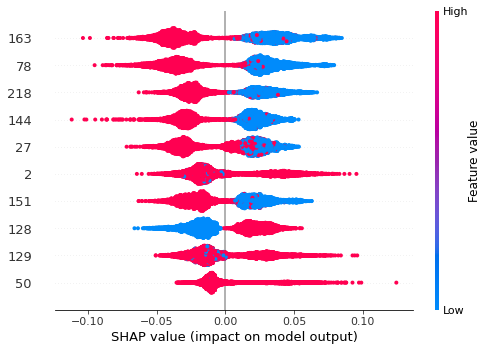

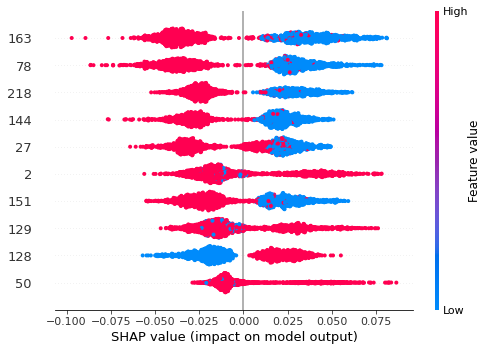

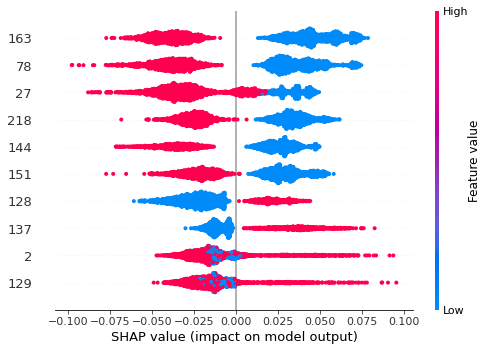

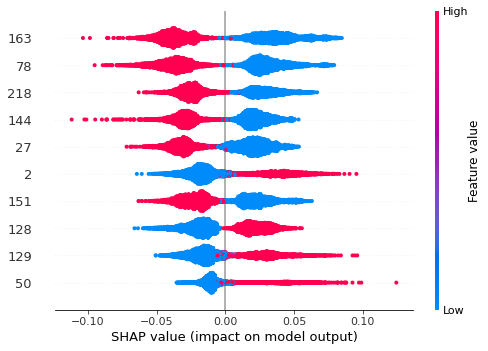

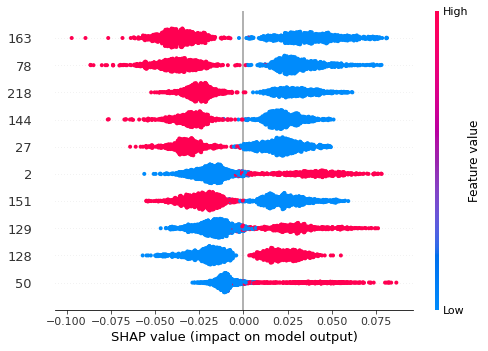

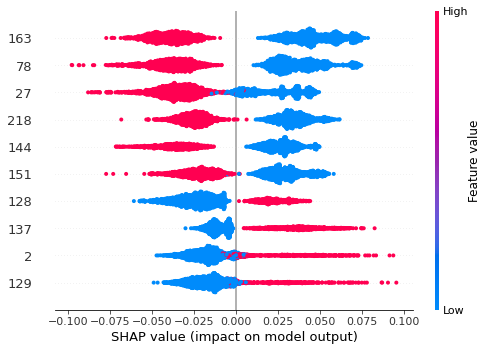

In [38]:
total_training_features = np.empty((0,len(feature_name)), float)
total_test_features = np.empty((0,len(feature_name)), float)
total_test_diff_features = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test_diff = np.empty((0,len(feature_name)), float)



for fold_num in range(cv_num):
    
    
    
    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%("binarized_zero",level,fold_num))
    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%("binarized_zero",level,fold_num))
    test_diff_features =  np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%("binarized_zero",level,fold_num))

    
    
    total_training_features = np.append(total_training_features,training_features,axis=0)
    total_test_features = np.append(total_test_features,test_features,axis=0)
    
    total_test_diff_features = np.append(total_test_diff_features,test_diff_features,axis=0)
    
    temp_randomforest_shap_values = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values = np.append(total_randomforest_shap_values,temp_randomforest_shap_values,axis=0)
    
    
    temp_randomforest_shap_values_test = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test = np.append(total_randomforest_shap_values_test,temp_randomforest_shap_values_test,axis=0)
    
    
    temp_randomforest_shap_values_test_diff = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test_diff.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test_diff = np.append(total_randomforest_shap_values_test_diff,temp_randomforest_shap_values_test_diff,axis=0)
    
    
fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values,pd.DataFrame(total_training_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_training_binary_zero.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test,pd.DataFrame(total_test_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test_binary_zero.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test_diff,pd.DataFrame(total_test_diff_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test_diff_binary_zero.jpg'%(level,data_name), dpi=500, bbox_inches='tight')

total_training_features = np.empty((0,len(feature_name)), float)
total_test_features = np.empty((0,len(feature_name)), float)
total_test_diff_features = np.empty((0,len(feature_name)), float)


for fold_num in range(cv_num):
    
    
    
    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%("binarized_standard",level,fold_num))
    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%("binarized_standard",level,fold_num))
    test_diff_features =  np.load('../../Dataset/%s/%s/%s_test_diff_features.npy'%("binarized_standard",level,fold_num))

    total_training_features = np.append(total_training_features,training_features,axis=0)
    total_test_features = np.append(total_test_features,test_features,axis=0)
    
    total_test_diff_features = np.append(total_test_diff_features,test_diff_features,axis=0)

    
fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values,pd.DataFrame(total_training_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_training_binary_standard.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test,pd.DataFrame(total_test_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test_binary_standard.jpg'%(level,data_name), dpi=500, bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(8,8))
shap.summary_plot(total_randomforest_shap_values_test_diff,pd.DataFrame(total_test_diff_features,columns=feature_name) , max_display=display_num)
fig.savefig('../classification/%s/%s/SHAP_summary_plot/randomforest_test_diff_binary_standard.jpg'%(level,data_name), dpi=500, bbox_inches='tight')

                

# Total Score Evaluation and Comparison

In [39]:
standard_list = ["standard","0","0.001","0.01","0.1","1","10"]

table_array_comparison = np.zeros((3,len(standard_list),len(feature_name)))

In [40]:
def score_measuring_constant(score_features,score_shap_values,constant):
    score_vector  = np.zeros(score_features.shape[1])

    for feature_index in range(score_features.shape[1]):
        org_vector = score_features[:,feature_index].copy()

        under_values = score_shap_values[org_vector<=constant,feature_index]
        over_values = score_shap_values[org_vector>constant,feature_index]

        pos = (np.sum(under_values<0)+np.sum(over_values>=0))/score_features.shape[0]
        neg = (np.sum(under_values>=0)+np.sum(over_values<0))/score_features.shape[0]

        score_vector[feature_index] = np.max([pos,neg])
    return score_vector

In [41]:
def moving_average(array,window):
    result = np.zeros((array.shape[0]-window+1))
    for i in range(result.shape[0]):
        result[i] = np.average(array[i:i+window])
    return result

In [42]:
total_training_features = np.empty((0,len(feature_name)), float)
total_test_features = np.empty((0,len(feature_name)), float)
total_test_diff_features = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test = np.empty((0,len(feature_name)), float)
total_randomforest_shap_values_test_diff = np.empty((0,len(feature_name)), float)

score_standard_training = np.empty((0,len(feature_name)), float)
score_standard_test = np.empty((0,len(feature_name)), float)
score_standard_test_diff = np.empty((0,len(feature_name)), float)

for fold_num in range(cv_num):

    training_features = np.load('../../Dataset/%s/%s/%s_training_features.npy'%(data_name,level,fold_num))
    test_features = np.load('../../Dataset/%s/%s/%s_test_features.npy'%(data_name,level,fold_num))
    test_diff_features =  np.load('../../Dataset/raw/%s/external_features.npy'%(level))
    
    
    total_training_features = np.append(total_training_features,training_features,axis=0)
    total_test_features = np.append(total_test_features,test_features,axis=0)
    
    total_test_diff_features = np.append(total_test_diff_features,test_diff_features,axis=0)
    
    temp_randomforest_shap_values = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values = np.append(total_randomforest_shap_values,temp_randomforest_shap_values,axis=0)
    
    
    temp_randomforest_shap_values_test = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test = np.append(total_randomforest_shap_values_test,temp_randomforest_shap_values_test,axis=0)
    
    
    temp_randomforest_shap_values_test_diff = np.load("../classification/%s/%s/shap_values/%s_randomforest_shap_values_test_diff.npy"%(level,data_name,fold_num)).copy()
    total_randomforest_shap_values_test_diff = np.append(total_randomforest_shap_values_test_diff,temp_randomforest_shap_values_test_diff,axis=0)


    temp_score_standard_training = np.load("../classification/%s/%s/standard/%s_standard_score_training.npy"%(level,data_name,fold_num)).copy().reshape(1,-1)
    score_standard_training = np.append(score_standard_training,temp_score_standard_training,axis=0)
    
    
    temp_score_standard_test = np.load("../classification/%s/%s/standard/%s_standard_score_test.npy"%(level,data_name,fold_num)).copy().reshape(1,-1)
    score_standard_test = np.append(score_standard_test,temp_score_standard_test,axis=0)
    
    
    temp_score_standard_test_diff = np.load("../classification/%s/%s/standard/%s_standard_score_test_diff.npy"%(level,data_name,fold_num)).copy().reshape(1,-1)
    score_standard_test_diff = np.append(score_standard_test_diff,temp_score_standard_test_diff,axis=0)

In [43]:
randomforest_shap = np.average(np.abs(total_randomforest_shap_values.copy()),axis=0)
randomforest_shap = randomforest_shap.reshape(len(feature_name),)
rank = randomforest_shap.argsort()[::-1]

    

### Training dataset

In [44]:

# training
standard_list = ["standard","0","0.001","0.01","0.1","1","10"]
score_df= pd.DataFrame(columns=standard_list,index=feature_name[rank[0:len(feature_name)]])

for index_st,name_st in enumerate(standard_list):
    if name_st == "standard":
#         for rank_index in rank[0:len(feature_name)]:
        score_df.loc[:,'%s'%name_st] = np.average(score_standard_training,axis=0)[rank[0:len(feature_name)]]
    else:
        score_vector = score_measuring_constant(total_training_features,total_randomforest_shap_values,float(name_st))
        score_df.loc[:,'%s'%name_st] = score_vector[rank[0:len(feature_name)]]
            
    table_array_comparison[0,index_st,:] =    score_df.loc[:,'%s'%name_st]
    

In [45]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

False
True


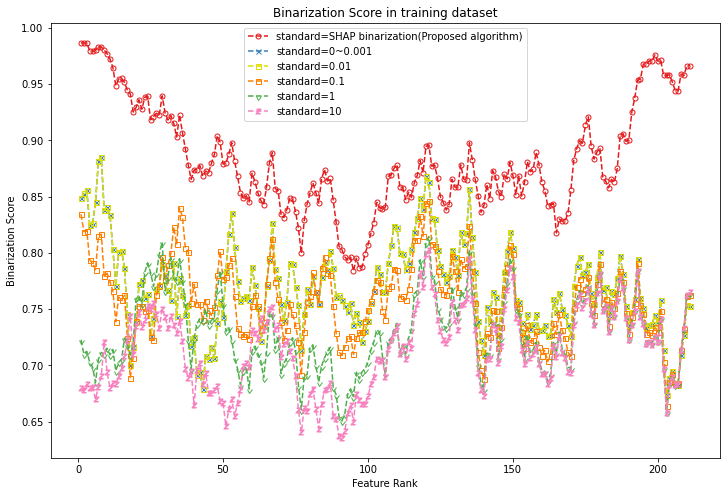

In [46]:

window =10

print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.01'],window)))
print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.001'],window)))

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['standard'],window),'#e41a1c',linestyle='--', marker='o',mfc='none', markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0'],window),'#377eb8',linestyle='--',marker='x',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.01'],window),'#dede00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.1'],window),'#ff7f00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['1'],window),'#4daf4a',linestyle='--',marker=11,mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['10'],window),'#f781bf',linestyle='--',marker='$Z$',mfc='none',  markersize=5)
plt.legend(["standard=SHAP binarization(Proposed algorithm)","standard=0~0.001","standard=0.01","standard=0.1","standard=1","standard=10"])
plt.xlabel("Feature Rank")
plt.ylabel("Binarization Score")
plt.title("Binarization Score in training dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_training_%s.jpg'%(level,window), dpi=500, bbox_inches='tight')
plt.show()


### Test Dataset

In [47]:
standard_list = ["standard","0","0.001","0.01","0.1","1","10"]
score_df= pd.DataFrame(columns=standard_list,index=feature_name[rank[0:len(feature_name)]])

for index_st,name_st in enumerate(standard_list):
    if name_st == "standard":
#         for rank_index in rank[0:len(feature_name)]:
        score_df.loc[:,'%s'%name_st] = np.average(score_standard_test,axis=0)[rank[0:len(feature_name)]]
    else:
        score_vector = score_measuring_constant(total_test_features,total_randomforest_shap_values_test,float(name_st))
        score_df.loc[:,'%s'%name_st] = score_vector[rank[0:len(feature_name)]]
        
    table_array_comparison[1,index_st,:] =    score_df.loc[:,'%s'%name_st]
            


False
True


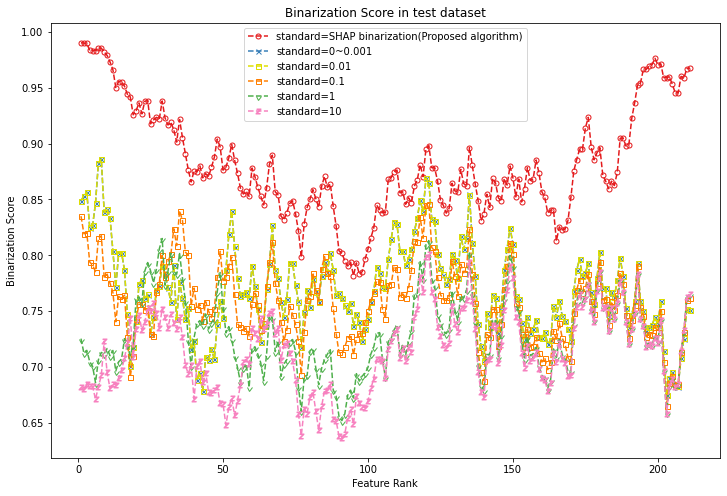

In [48]:
 

window =10

print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.01'],window)))
print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.001'],window)))

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['standard'],window),'#e41a1c',linestyle='--', marker='o',mfc='none', markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0'],window),'#377eb8',linestyle='--',marker='x',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.01'],window),'#dede00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.1'],window),'#ff7f00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['1'],window),'#4daf4a',linestyle='--',marker=11,mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['10'],window),'#f781bf',linestyle='--',marker='$Z$',mfc='none',  markersize=5)
plt.legend(["standard=SHAP binarization(Proposed algorithm)","standard=0~0.001","standard=0.01","standard=0.1","standard=1","standard=10"])
plt.xlabel("Feature Rank")
plt.ylabel("Binarization Score")
plt.title("Binarization Score in test dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_test_%s.jpg'%(level,window), dpi=500, bbox_inches='tight')
plt.show()


### External Set

In [49]:
# test_diff
standard_list = ["standard","0","0.001","0.01","0.1","1","10"]
score_df= pd.DataFrame(columns=standard_list,index=feature_name[rank[0:len(feature_name)]])

for index_st,name_st in enumerate(standard_list):
    if name_st == "standard":
#         for rank_index in rank[0:len(feature_name)]:
        score_df.loc[:,'%s'%name_st] = np.average(score_standard_test_diff,axis=0)[rank[0:len(feature_name)]]
    else:
        score_vector = score_measuring_constant(total_test_diff_features,total_randomforest_shap_values_test_diff,float(name_st))
        score_df.loc[:,'%s'%name_st] = score_vector[rank[0:len(feature_name)]]
    table_array_comparison[2,index_st,:] =    score_df.loc[:,'%s'%name_st]
            


True
True


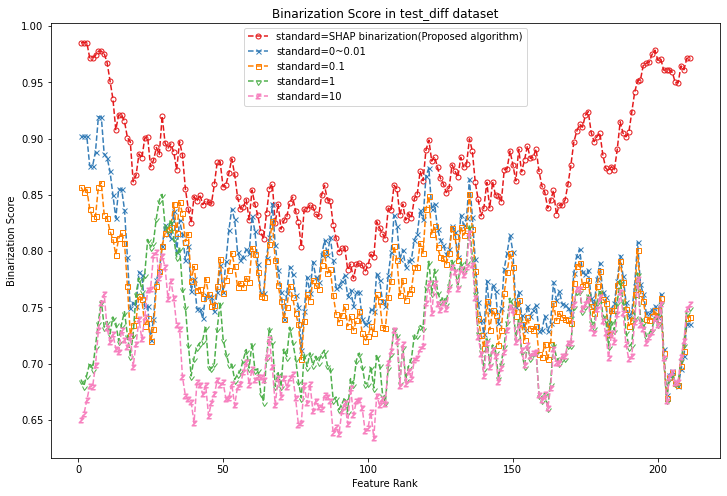

In [50]:


window =10

print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.01'],window)))
print(all(moving_average(score_df['0'],window)==moving_average(score_df['0.001'],window)))

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['standard'],window),'#e41a1c',linestyle='--', marker='o',mfc='none', markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0'],window),'#377eb8',linestyle='--',marker='x',mfc='none',  markersize=5)
# plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.01'],window),'#dede00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['0.1'],window),'#ff7f00',linestyle='--',marker='s',mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['1'],window),'#4daf4a',linestyle='--',marker=11,mfc='none',  markersize=5)
plt.plot(np.arange(1,len(feature_name)-window+2),moving_average(score_df['10'],window),'#f781bf',linestyle='--',marker='$Z$',mfc='none',  markersize=5)
plt.legend(["standard=SHAP binarization(Proposed algorithm)","standard=0~0.01","standard=0.1","standard=1","standard=10"])
plt.xlabel("Feature Rank")
plt.ylabel("Binarization Score")
plt.title("Binarization Score in test_diff dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_test_diff_%s.jpg'%(level,window), dpi=500, bbox_inches='tight')
plt.show()


In [51]:
##############species###############


score_file_org=openpyxl.load_workbook('../graph/SHAP/binarization_score/%s_score_comparison.xlsx'%level)
score_file = score_file_org.active

alphabet = ['A','B','C','D','E','F','G','H']

for index_st,name_st in enumerate(standard_list):
    
    score_file['%s1'%(alphabet[index_st+1])] = name_st
    
    
    
score_file['A1'] = "Training Dataset"
score_file['A2'] = "Total Average"
score_file['A3'] = "Top 10 ranked features"
score_file['A4'] = "Top 20 ranked features"
score_file['A5'] = "Top 30 ranked features"
score_file['A6'] = "Top 40 ranked features"
score_file['A7'] = "Top 50 ranked features"

for index_st,name_st in enumerate(standard_list):
    
    score_file['%s2'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison,axis=2)[0][index_st],2)
    score_file['%s3'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:10],axis=2)[0][index_st],2)
    score_file['%s4'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:20],axis=2)[0][index_st],2)
    score_file['%s5'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:30],axis=2)[0][index_st],2)
    score_file['%s6'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:40],axis=2)[0][index_st],2)
    score_file['%s7'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:50],axis=2)[0][index_st],2)

    

for index_st,name_st in enumerate(standard_list):
    score_file['%s8'%(alphabet[index_st+1])] = name_st
    
score_file['A8'] = "Test Dataset"
score_file['A9'] = "Total Average"
score_file['A10'] = "Top 10 ranked features"
score_file['A11'] = "Top 20 ranked features"
score_file['A12'] = "Top 30 ranked features"
score_file['A13'] = "Top 40 ranked features"
score_file['A14'] = "Top 50 ranked features"

for index_st,name_st in enumerate(standard_list):
    
    score_file['%s9'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison,axis=2)[1][index_st],2)
    score_file['%s10'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:10],axis=2)[1][index_st],2)
    score_file['%s11'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:20],axis=2)[1][index_st],2)
    score_file['%s12'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:30],axis=2)[1][index_st],2)
    score_file['%s13'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:40],axis=2)[1][index_st],2)
    score_file['%s14'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:50],axis=2)[1][index_st],2)

    
    
    
for index_st,name_st in enumerate(standard_list):
    score_file['%s15'%(alphabet[index_st+1])] = name_st
    
score_file['A15'] = "Test Dataset"
score_file['A16'] = "Total Average"
score_file['A17'] = "Top 10 ranked features"
score_file['A18'] = "Top 20 ranked features"
score_file['A19'] = "Top 30 ranked features"
score_file['A20'] = "Top 40 ranked features"
score_file['A21'] = "Top 50 ranked features"

for index_st,name_st in enumerate(standard_list):
    
    score_file['%s16'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison,axis=2)[2][index_st],2)
    score_file['%s17'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:10],axis=2)[2][index_st],2)
    score_file['%s18'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:20],axis=2)[2][index_st],2)
    score_file['%s19'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:30],axis=2)[2][index_st],2)
    score_file['%s20'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:40],axis=2)[2][index_st],2)
    score_file['%s21'%(alphabet[index_st+1])] = np.round(np.average(table_array_comparison[:,:,:50],axis=2)[2][index_st],2)

    

score_file_org.save("../graph/SHAP/binarization_score/%s_score_comparison.xlsx"%level)


In [52]:
table_array_comparison.shape


(3, 7, 220)

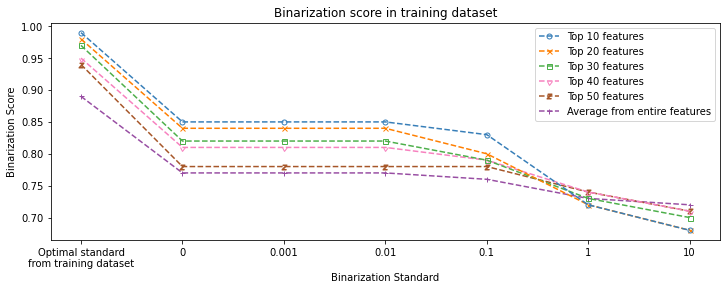

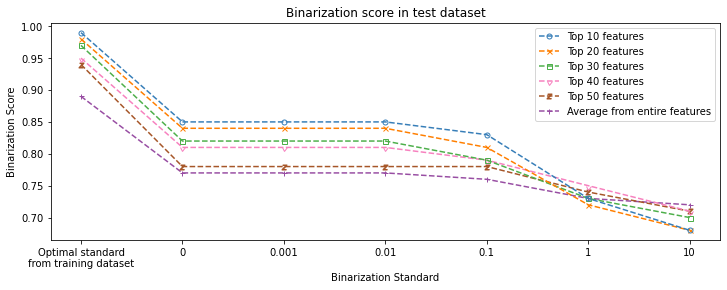

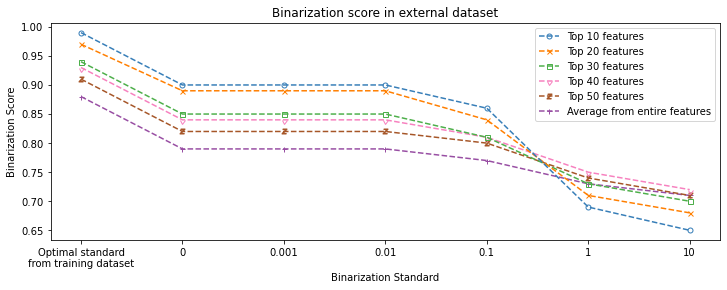

In [53]:
standard_name_list = ["Optimal standard\nfrom training dataset","0","0.001","0.01","0.1","1","10"]

plt.figure(figsize=(12, 4))
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:10],axis=2)[0],2),CB_color_cycle[0],linestyle='--', marker='o',mfc='none', markersize=5,zorder=6)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:20],axis=2)[0],2),CB_color_cycle[1],linestyle='--', marker='x',mfc='none', markersize=5,zorder=5)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:30],axis=2)[0],2),CB_color_cycle[2],linestyle='--', marker='s',mfc='none', markersize=5,zorder=4)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:40],axis=2)[0],2),CB_color_cycle[3],linestyle='--', marker=11,mfc='none', markersize=5,zorder=3)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:50],axis=2)[0],2),CB_color_cycle[4],linestyle='--', marker='$Z$',mfc='none', markersize=5,zorder=2)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison,axis=2)[0],2),CB_color_cycle[5],linestyle='--', marker='+',mfc='none', markersize=5,zorder=1)
plt.legend(["Top 10 features","Top 20 features","Top 30 features","Top 40 features","Top 50 features","Average from entire features"])
plt.xlabel("Binarization Standard")
plt.ylabel("Binarization Score")
plt.title("Binarization score in training dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_training.jpg'%(level), dpi=500, bbox_inches='tight')
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:10],axis=2)[1],2),CB_color_cycle[0],linestyle='--', marker='o',mfc='none', markersize=5,zorder=6)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:20],axis=2)[1],2),CB_color_cycle[1],linestyle='--', marker='x',mfc='none', markersize=5,zorder=5)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:30],axis=2)[1],2),CB_color_cycle[2],linestyle='--', marker='s',mfc='none', markersize=5,zorder=4)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:40],axis=2)[1],2),CB_color_cycle[3],linestyle='--', marker=11,mfc='none', markersize=5,zorder=3)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:50],axis=2)[1],2),CB_color_cycle[4],linestyle='--', marker='$Z$',mfc='none', markersize=5,zorder=2)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison,axis=2)[1],2),CB_color_cycle[5],linestyle='--', marker='+',mfc='none', markersize=5,zorder=1)
plt.legend(["Top 10 features","Top 20 features","Top 30 features","Top 40 features","Top 50 features","Average from entire features"])
plt.xlabel("Binarization Standard")
plt.ylabel("Binarization Score")
plt.title("Binarization score in test dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_test.jpg'%(level), dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:10],axis=2)[2],2),CB_color_cycle[0],linestyle='--', marker='o',mfc='none', markersize=5,zorder=6)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:20],axis=2)[2],2),CB_color_cycle[1],linestyle='--', marker='x',mfc='none', markersize=5,zorder=5)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:30],axis=2)[2],2),CB_color_cycle[2],linestyle='--', marker='s',mfc='none', markersize=5,zorder=4)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:40],axis=2)[2],2),CB_color_cycle[3],linestyle='--', marker=11,mfc='none', markersize=5,zorder=3)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison[:,:,:50],axis=2)[2],2),CB_color_cycle[4],linestyle='--', marker='$Z$',mfc='none', markersize=5,zorder=2)
plt.plot(standard_name_list,np.round(np.average(table_array_comparison,axis=2)[2],2),CB_color_cycle[5],linestyle='--', marker='+',mfc='none', markersize=5,zorder=1)
plt.legend(["Top 10 features","Top 20 features","Top 30 features","Top 40 features","Top 50 features","Average from entire features"])
plt.xlabel("Binarization Standard")
plt.ylabel("Binarization Score")
plt.title("Binarization score in external dataset")
plt.savefig('../graph/SHAP/binarization_score/%s_test_diff.jpg'%(level), dpi=500, bbox_inches='tight')
plt.show()

# Concentration of SHAP values for top ten features

In [ ]:
shap_abs = np.average(np.abs(total_randomforest_shap_values),axis=0)
# print(feature_name[shap_abs.argsort()[::-1]])
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

shap_abs = np.average(np.abs(total_randomforest_shap_values_test),axis=0)
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

shap_abs = np.average(np.abs(total_randomforest_shap_values_test_diff),axis=0)
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values),axis=0)
# print(feature_name[shap_abs.argsort()[::-1]])
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values_test),axis=0)
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values_test_diff),axis=0)
print(np.average(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.average(shap_abs))

In [ ]:
shap_abs = np.average(np.abs(total_randomforest_shap_values),axis=0)
# print(feature_name[shap_abs.argsort()[::-1]])
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))

shap_abs = np.average(np.abs(total_randomforest_shap_values_test),axis=0)
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))

shap_abs = np.average(np.abs(total_randomforest_shap_values_test_diff),axis=0)
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values),axis=0)
# print(feature_name[shap_abs.argsort()[::-1]])
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values_test),axis=0)
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))

shap_abs = np.average(np.abs(total_mlp_shap_values_test_diff),axis=0)
print(np.sum(shap_abs[shap_abs.argsort()[::-1][0:10]])/np.sum(shap_abs))